In [1]:
#import libraries
import re
import nltk
import sklearn
import os
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# Update path for your file
tweets_5G = 'PATH_TO_CONFIRMED_CONSPIRACY_TWEETS_DATASET.csv'

tweet_data = pd.read_csv(tweets_5G, sep = ",", engine='python')

In [3]:
# remove all rows with non-English tweet text content, as per Twitter's machine-detection
# https://towardsdatascience.com/how-to-filter-rows-of-a-pandas-dataframe-by-column-value-51996ea621f8

lang_truth_table = tweet_data.lang.str.contains('en')
tweets = tweet_data[lang_truth_table]
tweets.shape

(630, 19)

In [4]:
print('Number of rows removed: ' + str(tweet_data.shape[0] - tweets.shape[0]) + '/' + str(tweet_data.shape[0]) + '')
print('Percentage of English-language tweets is ' + str(round(tweets.shape[0] / tweet_data.shape[0] * 100, 1)) + '%')

Number of rows removed: 757/1387
Percentage of English-language tweets is 45.4%


In [5]:
# drop unnecessary columns 
# https://cmdlinetips.com/2018/04/how-to-drop-one-or-more-columns-in-pandas-dataframe/

tweets = tweets.drop(['from_user', 'lang', 'time', 'user_followers_count', 'user_friends_count', 'favorite_count        ', 'retweet_count        ', 'created_at', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'from_user_id_str', 'in_reply_to_status_id_str',  'source',  'profile_image_url',  'user_location',  'status_url',  'entities_str'], axis=1)

In [6]:
# extract hashtags from tweet text content and create new column 'hashtags' in lower case
# https://towardsdatascience.com/basic-tweet-preprocessing-in-python-efd8360d529e

def lower_case(x):
    result = []
    for word in x:
        result.append(word.lower())
    return result

tweets['hashtags'] = tweets['text'].apply(lambda x: re.findall(r"#(\w+)", x))
tweets['hashtags'] = tweets['hashtags'].apply(lambda x: lower_case(x))

In [7]:
# clean tweets from url's, mentions, hashtags, reserved words (RT, FAV), emojis and smileys, and numbers
# also, makes the cleaned text lowercase

import preprocessor as p
p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.HASHTAG, p.OPT.RESERVED, p.OPT.EMOJI, p.OPT.SMILEY)
list = []

for i,v in enumerate(tweets['text']):
    list.append( p.clean(v).lower() )
    
tweets['text_cleaned'] = list

In [8]:
# remove extra white spaces and punctuation

list = []

for i,v in enumerate(tweets['text_cleaned']):
    tweet = re.sub('&amp;', '', v)
    tweet = re.sub('[^\w\s]', '', tweet)
    tweet = re.sub('\s\s+', ' ', tweet)
    
    if tweet[0] == ' ':
        tweet = tweet[1:]
    
    list.append(tweet)

tweets['text_cleaned'] = list

In [9]:
# remove stop words with gensim
# https://www.kaggle.com/sreejiths0/efficient-tweet-preprocessing

from gensim.parsing.preprocessing import remove_stopwords

list = []

for i,v in enumerate(tweets['text_cleaned']):
    text = remove_stopwords(v)
    list.append(text)

tweets['text_cleaned'] = list

In [10]:
# remove rows which feature only one word in cleaned text

lang_truth_table = tweets.text_cleaned.str.contains(' ')
tweets = tweets[lang_truth_table]

tweets.shape

(615, 4)

In [38]:
# create new column with words of a tweet as a list

list = []

for i,v in enumerate(tweets['text_cleaned']):
    words = v.split(' ')
    list.append(words)

tweets['words_cleaned'] = list

In [12]:
# lemmatization

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def get_lemma(x):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(words) for words in x]

tweets['words_cleaned'] = tweets['words_cleaned'].apply(lambda x : get_lemma(x))
tweets['words_cleaned'].head(5)

0     [prevent, discovering, grey, spreading, leylines]
2     [john, fitzgerald, kennedy, told, truth, thats...
3                                         [thread, web]
9     [danger, 5g, network, radiation, smartphones, ...
16                                 [trying, tell, yall]
Name: words_cleaned, dtype: object

In [13]:
# removal of duplicate words
# https://stackoverflow.com/questions/8200342/removing-duplicate-strings-from-a-list-in-python
def remove_duplicates(x):
    seen = set()
    result = []
    for word in x:
        if word not in seen:
            seen.add(word)
            result.append(word)
    return result

tweets['words_cleaned'] = tweets['words_cleaned'].apply(lambda x : remove_duplicates(x))
tweets['words_cleaned'].head(7)

0     [prevent, discovering, grey, spreading, leylines]
2     [john, fitzgerald, kennedy, told, truth, thats...
3                                         [thread, web]
9     [danger, 5g, network, radiation, smartphones, ...
16                                 [trying, tell, yall]
18    [dr, andrew, kaufman, clearly, mention, insult...
20    [film, american, shot, shelter, place, english...
Name: words_cleaned, dtype: object

In [14]:
# removal of words and strings with a length of one (e.g. 'w/' i.e. 'w', which is a stopword)
# ALSO we allow removing '5g', since its a collection word (we are using it to fetch the data)

def remove_one_character_strings(x):
    result = []
    for word in x:
        if len(word) > 2 or word == '4g' or word == '3g':
            result.append(word)
    return result

tweets['words_cleaned'] = tweets['words_cleaned'].apply(lambda x : remove_one_character_strings(x))
tweets['words_cleaned'].head(20)

0     [prevent, discovering, grey, spreading, leylines]
2     [john, fitzgerald, kennedy, told, truth, thats...
3                                         [thread, web]
9     [danger, network, radiation, smartphones, secret]
16                                 [trying, tell, yall]
18    [andrew, kaufman, clearly, mention, insult, ca...
20    [film, american, shot, shelter, place, english...
21                                        [run, rabbit]
22    [corona, virus, hoax, fake, death, mike, decke...
24    [seen, video, guy, claiming, new, british, pou...
32    [2nd, spike, shut, antimaskers, hysterical, ph...
35                                  [spectrum, defence]
36    [coronavirus, youtube, tightens, rule, david, ...
37                                     [download, asap]
38                              [omg, look, real, fact]
47    [patent, research, nervous, manipulation, elec...
49             [here, video, appears, purporting, need]
50    [havent, heard, need, aware, here, appears

In [15]:
# ______ MOST COMMON WORDS _______

In [16]:
# flatten list of all words in all tweets and create a list of collections with the words and their counts

import itertools
import collections

# clear list variable, since it gets initialized for some reason
# and this then breaks the following 
del list

# List of all words across tweets
all_words = list(itertools.chain(*tweets['words_cleaned']))

# Create counter
counts = collections.Counter(all_words)

counts.most_common(15)

[('radiation', 122),
 ('people', 52),
 ('tower', 51),
 ('health', 48),
 ('video', 36),
 ('stop', 36),
 ('world', 36),
 ('technology', 33),
 ('virus', 32),
 ('wireless', 32),
 ('share', 30),
 ('vaccine', 29),
 ('emf', 27),
 ('microwave', 26),
 ('safety', 25)]

In [17]:
clean_tweets = pd.DataFrame(counts.most_common(100),
                             columns=['words', 'count'])

clean_tweets.head(10)

,words,count
0,radiation,122
1,people,52
2,tower,51
3,health,48
4,video,36
5,stop,36
6,world,36
7,technology,33
8,virus,32
9,wireless,32


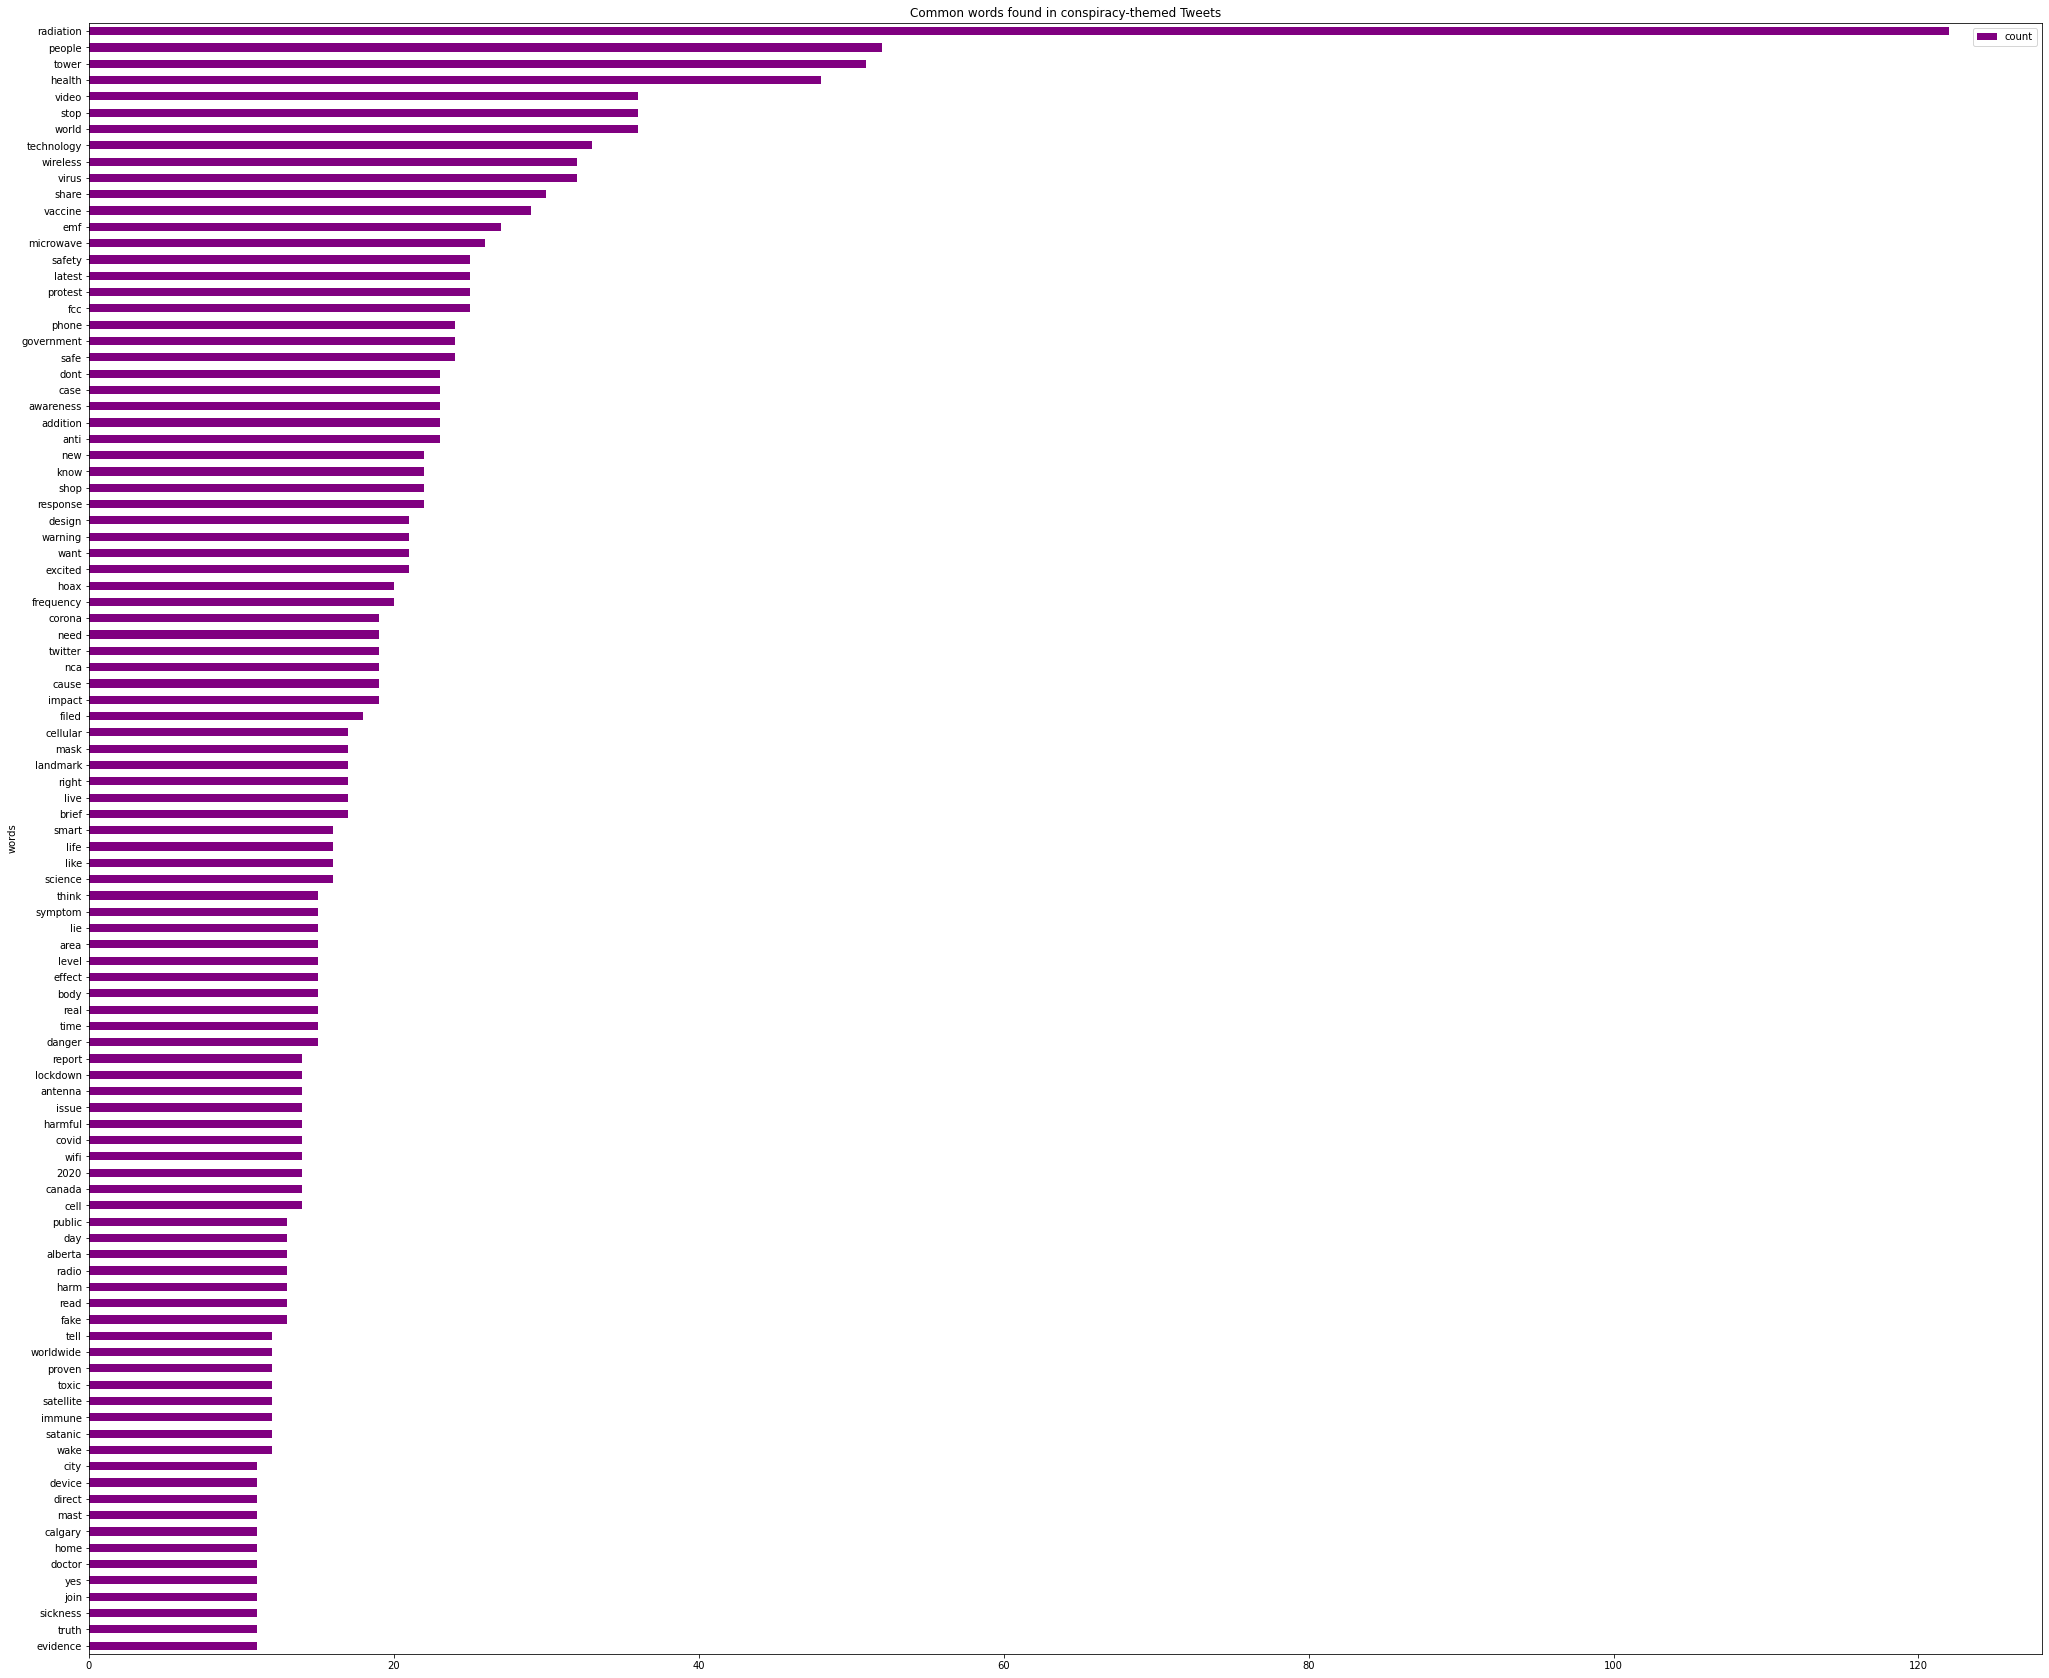

In [18]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(35, 30))

# Plot horizontal bar graph
clean_tweets.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common words found in conspiracy-themed Tweets")

plt.show()

In [19]:
# _____ TF-IDF ______

In [20]:
# turn lists of strings into strings, divided with commas

def combineIntoString(x):
    return ', '.join(x)

tweets['text_cleaned'] = tweets['words_cleaned'].apply(lambda x : combineIntoString(x))
tweets['text_cleaned'].head(7)

0       prevent, discovering, grey, spreading, leylines
2     john, fitzgerald, kennedy, told, truth, thats,...
3                                           thread, web
9       danger, network, radiation, smartphones, secret
16                                   trying, tell, yall
18    andrew, kaufman, clearly, mention, insult, cau...
20    film, american, shot, shelter, place, english,...
Name: text_cleaned, dtype: object

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

def preProcessor(s):
    # we did all the preprocessing already, so return as is
    return s
    
pd.options.display.max_colwidth = 1000
pd.set_option('display.max_columns', None)

tfidf_vectorizer = TfidfVectorizer(preprocessor = preProcessor,
                                   max_df=0.75, min_df=3, use_idf=True)

text_tfidf = tfidf_vectorizer.fit_transform(tweets['text_cleaned'])

In [22]:
occ = np.asarray(text_tfidf.sum(axis=0)).ravel().tolist()
tfidf_scores = pd.DataFrame({'terms': tfidf_vectorizer.get_feature_names(), 'tfidf': occ})

tfidf_scores.sort_values('tfidf',ascending=False).head(20)

,terms,tfidf
454,radiation,22.206353
419,people,14.356913
545,stop,12.148230
593,tower,12.117365
263,health,12.057587
617,video,10.092710
635,wireless,9.639816
641,world,9.257292
615,vaccine,8.965297
510,share,8.790857


In [23]:
# ______ MOST COMMON HASHTAGS _______

In [24]:
# Then we check for the HASHTAGS

# flatten list of all hashtags in all tweets and create a list of collections with the words and their counts

import itertools
import collections

# clear list variable, since it gets initialized for some reason
# and this then breaks the following 
# del list

# List of all words across tweets
all_hashtags = list(itertools.chain(*tweets['hashtags']))

# Create counter
hashtag_counts = collections.Counter(all_hashtags)

hashtag_counts.most_common(20)

[('stop5g', 511),
 ('5g', 281),
 ('billgates', 89),
 ('emf', 67),
 ('cancer', 65),
 ('covid19', 60),
 ('radiation', 57),
 ('health', 54),
 ('stop4glte', 41),
 ('ehs', 30),
 ('coronavirus', 29),
 ('technocracy', 28),
 ('scomo', 28),
 ('nwo', 28),
 ('fitness', 27),
 ('emr', 26),
 ('vaccines', 24),
 ('5gdangers', 24),
 ('fcc', 23),
 ('5gnetwork', 23)]

In [25]:
clean_hashtags = pd.DataFrame(hashtag_counts.most_common(100),
                             columns=['words', 'count'])

clean_hashtags.head(10)

,words,count
0,stop5g,511
1,5g,281
2,billgates,89
3,emf,67
4,cancer,65
5,covid19,60
6,radiation,57
7,health,54
8,stop4glte,41
9,ehs,30


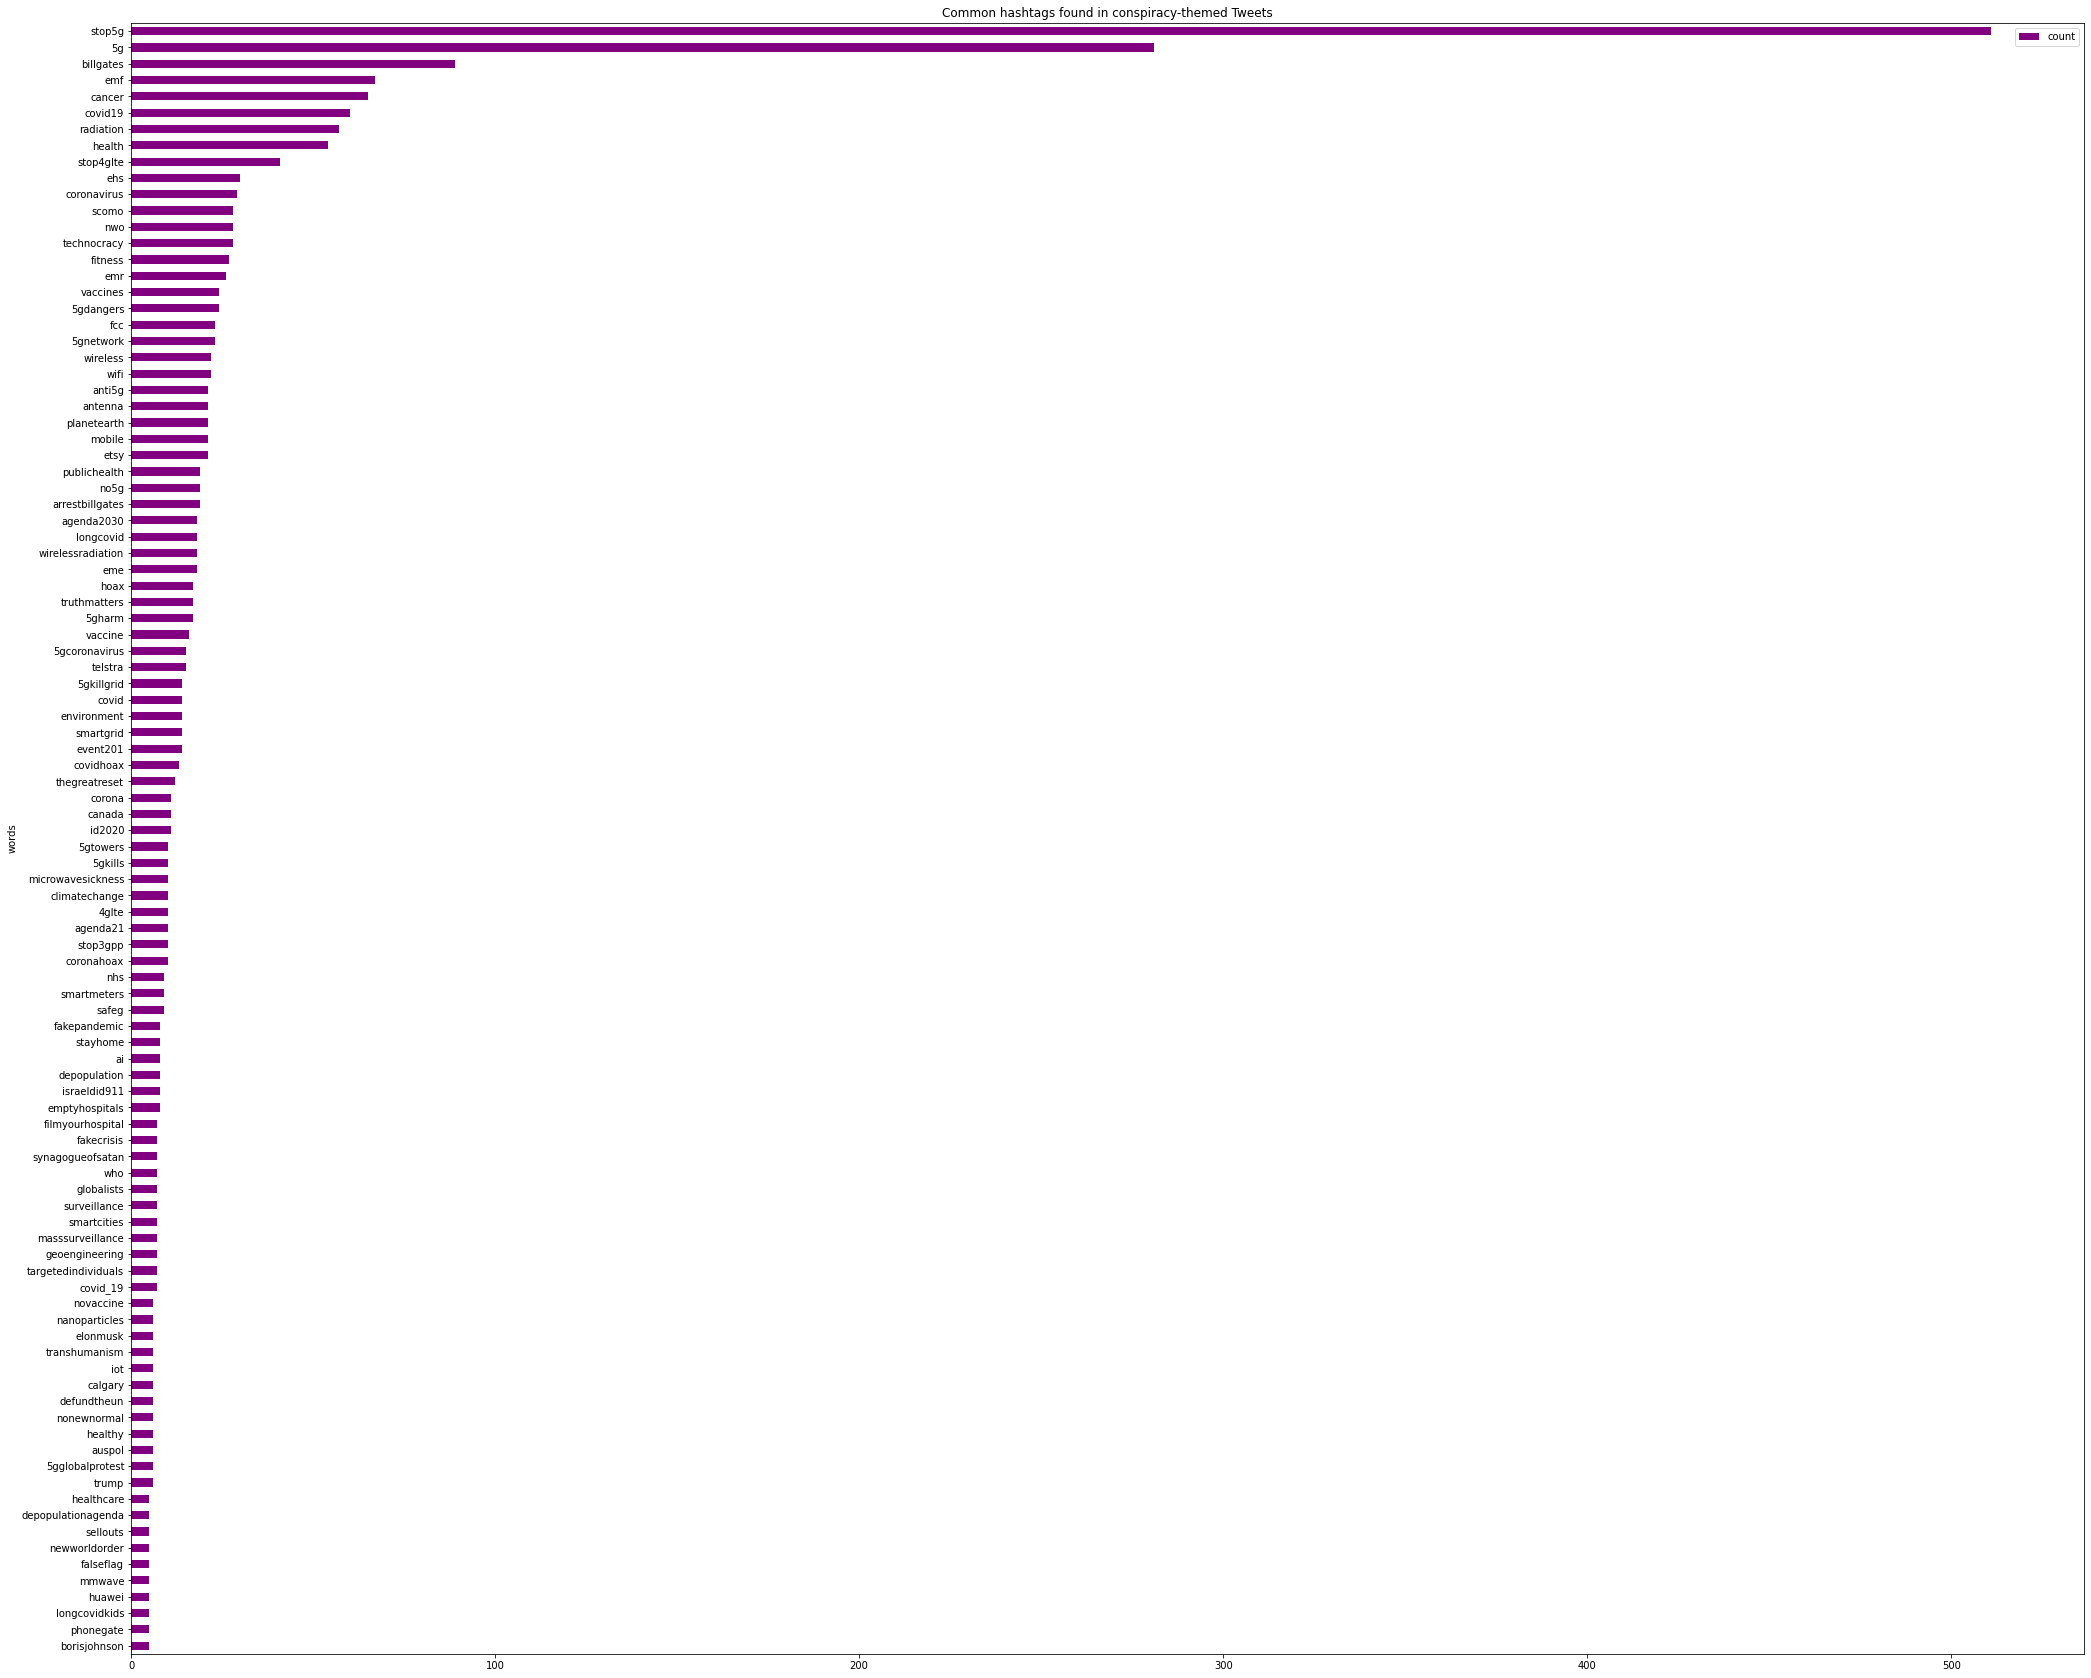

In [26]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(35, 30))

# Plot horizontal bar graph
clean_hashtags.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common hashtags found in conspiracy-themed Tweets")

plt.show()

In [27]:
# ______ TF-IDF ______

In [28]:
# turn lists of strings into strings, divided with commas

def combineIntoString(x):
    return ', '.join(x)

tweets['hashtags_cleaned'] = tweets['hashtags'].apply(lambda x : combineIntoString(x))
tweets['hashtags_cleaned'].head(7)

0                                                                                                                                                                                     5gcoronavirus, conspiracytheory, covid19
2                                                                                                                                                                      israel, federalreserve, illuminatiagenda, 5gcoronavirus
3     coronahoax, 5gcoronavirus, medicalmartiallaw, greatestdepression, globalcoup, 5gmindcontrol, billgatesisnotourfriend, billgatespublicenemy1, meetooabusedbypsychopaths, upriseofhumanityforsanity, maketheworldsaneagain
9                                                                                                                                 problemswith5g, 5g, 5gcoronavirus, smartphones, 5gconspiracy, smartphonesradiation, madsheep
16                                                                                                          

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

def preProcessor(s):
    # we did all the preprocessing already, so return as is
    return s
    
pd.options.display.max_colwidth = 1000
pd.set_option('display.max_columns', None)

tfidf_vectorizer = TfidfVectorizer(preprocessor = preProcessor,
                                   max_df=0.75, min_df=3, use_idf=True)

hashtag_tfidf = tfidf_vectorizer.fit_transform(tweets['hashtags_cleaned'])

In [30]:
occ_hashtag = np.asarray(hashtag_tfidf.sum(axis=0)).ravel().tolist()
tfidf_hashtag_scores = pd.DataFrame({'terms': tfidf_vectorizer.get_feature_names(), 'tfidf': occ_hashtag})

tfidf_hashtag_scores.sort_values('tfidf',ascending=False).head(20)

,terms,tfidf
3,5g,86.947705
27,billgates,34.849368
62,emf,25.683025
35,cancer,21.785820
47,covid19,20.247743
84,health,18.752715
134,radiation,18.733055
156,stop4glte,17.291937
24,arrestbillgates,16.918028
165,technocracy,13.552674


In [31]:
#################################### Creating list of words and hashtags for creating stopword list ####################################

In [32]:
# create list with 50 best-scored WORDS in regards of tf-idf

tfidf_scores.sort_values('tfidf',ascending=False)[:50]['terms'].head(50)

454     radiation
419        people
545          stop
593         tower
263        health
617         video
635      wireless
641         world
615       vaccine
510         share
619         virus
570    technology
217           fcc
188           emf
625       warning
127        corona
83           case
606       twitter
30           anti
323        latest
492        safety
444       protest
15       addition
391           new
369     microwave
388          need
249    government
176          dont
41      awareness
332           lie
422         phone
475      response
513          shop
320          know
583         think
622          want
288        impact
202       excited
160        design
223         filed
490          safe
322      landmark
67          brief
147        danger
562       symptom
231     frequency
84          cause
150           day
387           nca
462          real
Name: terms, dtype: object

In [33]:
# create list with 50 best-scored HASHTAGS in regards of tf-idf

tfidf_hashtag_scores.sort_values('tfidf',ascending=False)[:50]['terms'].head(50)

3                     5g
27             billgates
62                   emf
35                cancer
47               covid19
84                health
134            radiation
156            stop4glte
24       arrestbillgates
165          technocracy
184             wireless
122                  nwo
44           coronavirus
75                   fcc
5              5gdangers
183                 wifi
58                   ehs
101            longcovid
179             vaccines
49             covidhoax
132         publichealth
4          5gcoronavirus
142                scomo
119                 no5g
77               fitness
67           environment
66                   emr
8             5gkillgrid
185    wirelessradiation
11             5gnetwork
18            agenda2030
7                 5gharm
175         truthmatters
127          planetearth
23                anti5g
22               antenna
114               mobile
68                  etsy
139                safeg
149            smartgrid


In [34]:
# Create list of words, which is conspiracy_stop_words:

first_list = tfidf_scores.sort_values('tfidf',ascending=False)[:50]['terms']

second_list = tfidf_hashtag_scores.sort_values('tfidf',ascending=False)[:50]['terms']

# combine sets and transform into list
# https://stackoverflow.com/questions/1319338/combining-two-lists-and-removing-duplicates-without-removing-duplicates-in-orig
conspiracy_stop_words = list(set(first_list) | set(second_list))

# remove possible duplicates
conspiracy_stop_words = list(dict.fromkeys(conspiracy_stop_words))

conspiracy_stop_words

['awareness',
 'emr',
 'covidhoax',
 '5gkillgrid',
 'vaccine',
 'stop',
 'emf',
 'landmark',
 'covid19',
 'know',
 'environment',
 'smartgrid',
 'symptom',
 'microwavesickness',
 'want',
 'brief',
 'coronavirus',
 'shop',
 'safeg',
 'ehs',
 'agenda2030',
 '5gharm',
 'longcovid',
 'phone',
 '5gdangers',
 '5gtowers',
 'hoax',
 'world',
 'day',
 'dont',
 'billgates',
 'wireless',
 '5gnetwork',
 'technology',
 'scomo',
 'stop3gpp',
 'anti',
 'government',
 'frequency',
 'publichealth',
 'mobile',
 'cancer',
 'danger',
 'anti5g',
 'fcc',
 'arrestbillgates',
 'technocracy',
 'filed',
 'lie',
 '5g',
 'real',
 'video',
 'corona',
 'stop4glte',
 'new',
 'tower',
 'warning',
 'safe',
 'protest',
 'impact',
 'thegreatreset',
 'twitter',
 'radiation',
 'wifi',
 'antenna',
 'event201',
 'vaccines',
 'safety',
 'fitness',
 'nca',
 '5gcoronavirus',
 'share',
 'etsy',
 'truthmatters',
 'planetearth',
 '5gkills',
 'addition',
 'no5g',
 'case',
 'need',
 'latest',
 'health',
 'wirelessradiation',
 'covi

In [35]:
# create file with conspiracy_stop_words

with open('/Users/mikipernu/Desktop/sma-2020/conspiracy_stopwords/conspiracy_stop_words_generated.txt', 'w') as f:
    for item in conspiracy_stop_words:
        f.write(str(item) + '\n')
    f.close()

In [36]:
# List of hashtags is used as conspiracy_stop_hashtags:

# transform into list
conspiracy_stop_hashtags = list(tfidf_hashtag_scores.sort_values('tfidf',ascending=False)[:50]['terms'])

conspiracy_stop_hashtags

['5g',
 'billgates',
 'emf',
 'cancer',
 'covid19',
 'health',
 'radiation',
 'stop4glte',
 'arrestbillgates',
 'technocracy',
 'wireless',
 'nwo',
 'coronavirus',
 'fcc',
 '5gdangers',
 'wifi',
 'ehs',
 'longcovid',
 'vaccines',
 'covidhoax',
 'publichealth',
 '5gcoronavirus',
 'scomo',
 'no5g',
 'fitness',
 'environment',
 'emr',
 '5gkillgrid',
 'wirelessradiation',
 '5gnetwork',
 'agenda2030',
 '5gharm',
 'truthmatters',
 'planetearth',
 'anti5g',
 'antenna',
 'mobile',
 'etsy',
 'safeg',
 'smartgrid',
 'covid',
 'hoax',
 'thegreatreset',
 'stop3gpp',
 'eme',
 'microwavesickness',
 '5gtowers',
 '5gkills',
 'event201',
 'vaccine']

In [37]:
# create file with conspiracy_stop_hashtags

with open('/Users/mikipernu/Desktop/sma-2020/conspiracy_stopwords/conspiracy_stop_hashtags_generated.txt', 'w') as f:
    for item in conspiracy_stop_hashtags:
        f.write(str(item) + '\n')
    f.close()

In [ ]:
## Remove by hand the words and hashtags that are too general or feature both conspiratory and non-conspiratory content